In [30]:
# Imports
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, create_react_agent
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal, TypedDict, Annotated
import operator
import os

In [31]:
# Load API Key
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found!")

In [32]:
# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=openai_api_key
)

### ReAct Pattern

In [33]:
@tool
def calculator(expression: str) -> str:
    """
    Calculate mathematical expressions.
    
    Args:
        expression: Math expression like "2 + 2" or "15 * 37"
    """
    try:
        result = eval(expression, {"__builtins__": {}}, {})
        return str(result)
    except Exception as e:
        return f"Error: {str(e)}"
    
@tool
def search(query: str) -> str:
    """
    Search for information (simulated).
    
    Args:
        query: The search query
    """
    # Simulated search results
    knowledge = {
        "python": "Python is a high-level programming language created in 1991.",
        "langgraph": "LangGraph is a framework for building stateful multi-actor applications.",
        "react": "ReAct is an agent pattern that combines reasoning and acting."
    }

    for key, value in knowledge.items():
        if key in query.lower():
            return value

    return "No information found."

tools = [calculator, search]

#### ReAct - Manual implementation

In [34]:
# Bind tools to LLM
llm_with_tool = llm.bind_tools(tools)

# System prompt
react_prompt = SystemMessage(content="""You are a helpful assistant with tools.
                    
Use calculator fot the math and search for information.
Think step-by-step before using tools.""")

# Define nodes
def react_assistance(state: MessagesState) -> dict:
    """Agent node - reasons and decides which tool to use."""
    messages = [react_prompt] + state["messages"]
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    """Route to tools or end."""
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"

# build graph
react_builder = StateGraph(MessagesState)
react_builder.add_node("assistant", react_assistance)
react_builder.add_node("tools", ToolNode(tools))

react_builder.add_edge(START, "assistant")
react_builder.add_conditional_edges(
    "assistant",
    should_continue,
    {"tools": "tools", "__end__": END}
)
react_builder.add_edge("tools", "assistant")

react_agent_manual = react_builder.compile(checkpointer=MemorySaver())

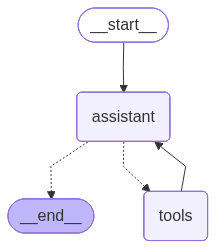

In [35]:
# Visualize
try:
    display(Image(react_agent_manual.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph: START → assistant ↔ tools → END")

##### Test Manual ReAct

In [36]:
def test_agent(agent, query: str, agent_name: str = "Agent"):
    print(f"\n{'='*80}")
    print(f"User: {query}")
    print(f"{agent_name} (FULL TRACE)")
    print(f"{'='*80}\n")

    result = agent.invoke(
        {"messages": [HumanMessage(content=query)]},
        config={"configurable": {"thread_id": f"test_{agent_name}"}}
    )

    for i, msg in enumerate(result["messages"]):
        print(f"\n--- Step {i+1} ---")

        if isinstance(msg, HumanMessage):
            print("👤 Human:")
            print(msg.content)

        elif isinstance(msg, AIMessage):
            print("Assistant:")
            print(msg.content)

            # 🔥 THIS IS IMPORTANT
            if msg.tool_calls:
                print("\n🛠 Tool Calls:")
                for tc in msg.tool_calls:
                    print(f"  • Tool name: {tc['name']}")
                    print(f"  • Arguments: {tc['args']}")

        elif isinstance(msg, ToolMessage):
            print("Tool Result:")
            print(f"Tool: {msg.name}")
            print(f"Output: {msg.content}")

    final_answer = result["messages"][-1].content

    print(f"\n{'='*80}")
    print("FINAL ANSWER:")
    print(final_answer)
    print(f"{'='*80}\n")

    return final_answer

In [37]:
# Multi-step test
test_agent(
    react_agent_manual,
    "What is react ?",
    "Manual ReAct_0"
)


User: What is react ?
Manual ReAct_0 (FULL TRACE)


--- Step 1 ---
👤 Human:
What is react ?

--- Step 2 ---
Assistant:


🛠 Tool Calls:
  • Tool name: search
  • Arguments: {'query': 'What is React?'}

--- Step 3 ---
Tool Result:
Tool: search
Output: ReAct is an agent pattern that combines reasoning and acting.

--- Step 4 ---
Assistant:
React is a popular JavaScript library used for building user interfaces, particularly for single-page applications where you need a fast and interactive user experience. It allows developers to create reusable UI components, manage the state of applications efficiently, and handle updates to the user interface in a declarative way.

Key features of React include:

1. **Component-Based Architecture**: React applications are built using components, which are reusable pieces of code that define how a certain part of the UI should look and behave.

2. **Virtual DOM**: React uses a virtual representation of the DOM to optimize rendering. When the state of a

'React is a popular JavaScript library used for building user interfaces, particularly for single-page applications where you need a fast and interactive user experience. It allows developers to create reusable UI components, manage the state of applications efficiently, and handle updates to the user interface in a declarative way.\n\nKey features of React include:\n\n1. **Component-Based Architecture**: React applications are built using components, which are reusable pieces of code that define how a certain part of the UI should look and behave.\n\n2. **Virtual DOM**: React uses a virtual representation of the DOM to optimize rendering. When the state of an object changes, React first changes the object in the virtual DOM, then it efficiently updates the real DOM.\n\n3. **Declarative Syntax**: React allows developers to describe what the UI should look like for any given state, making it easier to understand and debug.\n\n4. **Unidirectional Data Flow**: Data flows in one direction,

In [38]:
# Multi-step test
test_agent(
    react_agent_manual,
    "Search for information about Python, then calculate 2 ** 10",
    "Manual ReAct_2"
)


User: Search for information about Python, then calculate 2 ** 10
Manual ReAct_2 (FULL TRACE)


--- Step 1 ---
👤 Human:
Search for information about Python, then calculate 2 ** 10

--- Step 2 ---
Assistant:


🛠 Tool Calls:
  • Tool name: search
  • Arguments: {'query': 'Python programming language'}
  • Tool name: calculator
  • Arguments: {'expression': '2 ** 10'}

--- Step 3 ---
Tool Result:
Tool: search
Output: Python is a high-level programming language created in 1991.

--- Step 4 ---
Tool Result:
Tool: calculator
Output: 1024

--- Step 5 ---
Assistant:
Python is a high-level programming language created in 1991. It is known for its readability and simplicity, making it a popular choice for beginners and experienced developers alike.

The calculation of \(2^{10}\) equals 1024.

FINAL ANSWER:
Python is a high-level programming language created in 1991. It is known for its readability and simplicity, making it a popular choice for beginners and experienced developers alike.

The ca

'Python is a high-level programming language created in 1991. It is known for its readability and simplicity, making it a popular choice for beginners and experienced developers alike.\n\nThe calculation of \\(2^{10}\\) equals 1024.'

In [39]:
# Multi-step test
test_agent(
    react_agent_manual,
    "What is LLM",
    "Manual ReAct_33"
)


User: What is LLM
Manual ReAct_33 (FULL TRACE)


--- Step 1 ---
👤 Human:
What is LLM

--- Step 2 ---
Assistant:


🛠 Tool Calls:
  • Tool name: search
  • Arguments: {'query': 'What is LLM?'}

--- Step 3 ---
Tool Result:
Tool: search
Output: No information found.

--- Step 4 ---
Assistant:
LLM stands for "Large Language Model." It refers to a type of artificial intelligence model that is trained on vast amounts of text data to understand and generate human-like language. These models use deep learning techniques, particularly neural networks, to process and generate text based on the input they receive.

Key characteristics of LLMs include:

1. **Scale**: They are typically trained on billions or even trillions of parameters, which allows them to capture complex patterns in language.

2. **Versatility**: LLMs can perform a variety of language tasks, such as translation, summarization, question answering, and text generation.

3. **Contextual Understanding**: They can understand context

'LLM stands for "Large Language Model." It refers to a type of artificial intelligence model that is trained on vast amounts of text data to understand and generate human-like language. These models use deep learning techniques, particularly neural networks, to process and generate text based on the input they receive.\n\nKey characteristics of LLMs include:\n\n1. **Scale**: They are typically trained on billions or even trillions of parameters, which allows them to capture complex patterns in language.\n\n2. **Versatility**: LLMs can perform a variety of language tasks, such as translation, summarization, question answering, and text generation.\n\n3. **Contextual Understanding**: They can understand context and generate coherent and contextually relevant responses.\n\n4. **Pre-training and Fine-tuning**: LLMs are often pre-trained on a large corpus of text and then fine-tuned on specific tasks or datasets to improve their performance in particular applications.\n\nExamples of LLMs in

### ReAct - using Helper Functions

In [40]:
# Using create_react_agent helper
react_agent_helper = create_react_agent(
    model=llm,
    tools=tools,
    prompt=react_prompt
)

C:\Users\user234\AppData\Local\Temp\ipykernel_17528\2831844381.py:2: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  react_agent_helper = create_react_agent(


##### Test Helper ReAct

In [41]:
test_agent(react_agent_helper, "What is 123 * 456?", "Helper ReAct_0")


User: What is 123 * 456?
Helper ReAct_0 (FULL TRACE)


--- Step 1 ---
👤 Human:
What is 123 * 456?

--- Step 2 ---
Assistant:


🛠 Tool Calls:
  • Tool name: calculator
  • Arguments: {'expression': '123 * 456'}

--- Step 3 ---
Tool Result:
Tool: calculator
Output: 56088

--- Step 4 ---
Assistant:
The result of \( 123 \times 456 \) is 56,088.

FINAL ANSWER:
The result of \( 123 \times 456 \) is 56,088.



'The result of \\( 123 \\times 456 \\) is 56,088.'

In [42]:
from langchain.agents import create_agent

create_agent_helper = create_agent(
    model=llm,
    tools=tools,
    system_prompt=react_prompt
)

In [43]:
test_agent(create_agent_helper, "What is 123 * 456?", "Helper ReAct_1")


User: What is 123 * 456?
Helper ReAct_1 (FULL TRACE)


--- Step 1 ---
👤 Human:
What is 123 * 456?

--- Step 2 ---
Assistant:


🛠 Tool Calls:
  • Tool name: calculator
  • Arguments: {'expression': '123 * 456'}

--- Step 3 ---
Tool Result:
Tool: calculator
Output: 56088

--- Step 4 ---
Assistant:
The result of \( 123 \times 456 \) is 56,088.

FINAL ANSWER:
The result of \( 123 \times 456 \) is 56,088.



'The result of \\( 123 \\times 456 \\) is 56,088.'

In [44]:
# Same multi-step test
test_agent(
    react_agent_helper,
    "Search for information about LangGraph, then calculate 15 * 25",
    "Helper ReAct_0"
)


User: Search for information about LangGraph, then calculate 15 * 25
Helper ReAct_0 (FULL TRACE)


--- Step 1 ---
👤 Human:
Search for information about LangGraph, then calculate 15 * 25

--- Step 2 ---
Assistant:


🛠 Tool Calls:
  • Tool name: search
  • Arguments: {'query': 'LangGraph'}
  • Tool name: calculator
  • Arguments: {'expression': '15 * 25'}

--- Step 3 ---
Tool Result:
Tool: search
Output: LangGraph is a framework for building stateful multi-actor applications.

--- Step 4 ---
Tool Result:
Tool: calculator
Output: 375

--- Step 5 ---
Assistant:
LangGraph is a framework designed for building stateful multi-actor applications. 

Additionally, the calculation of \( 15 \times 25 \) results in \( 375 \).

FINAL ANSWER:
LangGraph is a framework designed for building stateful multi-actor applications. 

Additionally, the calculation of \( 15 \times 25 \) results in \( 375 \).



'LangGraph is a framework designed for building stateful multi-actor applications. \n\nAdditionally, the calculation of \\( 15 \\times 25 \\) results in \\( 375 \\).'

### Plan-execute Pattern

In [45]:
# Custom state for Plan-Execute
class PlanExecuteState(TypedDict):
    """State for plan-execute pattern."""
    input: str  # Original user query
    plan: list[str]  # List of steps
    current_step: int  # Which step we're on
    results: Annotated[list[str], operator.add]  # Results from each step
    final_output: str  # Final answer

In [48]:
# Node 1: Planner
def planner(state: PlanExecuteState) -> dict:
    """Create a step-by-step plan"""
    prompt = f"""Create a step-by-step plan for this task:
    
Task: {state['input']}

Return a numbered list of concrete steps. keep it simple (3-5 step)."""
    
    response = llm.invoke([HumanMessage(content=prompt)])

    # Parse step steps (simple parsing)
    lines = response.content.split('\n')
    steps = [line.strip() for line in lines if line.strip() and any(char.isdigit() for char in line[:3])]

    print(f"\nPLAN CREATED:")
    for step in steps:
        print(f"  {step}")
    print()

    return {"plan": steps, "current_step": 0, "results": []}

# Node 2: Executor
def executor(state: PlanExecuteState) -> dict:
    """Execute current step."""
    if state["current_step"] >= len(state["plan"]):
        # All steps done
        return {}
    
    current_step = state["plan"][state["current_step"]]

    print(f"Executing: {current_step}")

    # Execute step (simplified - just use LLM)
    print(f"Executing: {current_step}")

    # Execute step (simplified - just use LLM)
    prompt = f"""Previous results: {state.get('result', [])}\n\nExecute this step: {current_step}"""
    response = llm.invoke([HumanMessage(content=prompt)])

    result = f"Step {state['current_step'] + 1} result: {response.content}"
    print(result)
    print("Done\n")

    return {
        "results": [result],
        "current_step": state["current_step"] + 1
    }

# Node 3: Finalizer
def finalizer(state: PlanExecuteState) -> dict:
    """Create final output from all results."""
    prompt = f"""Combine these step results into a final answer:

Original task: {state['input']}

Results: {state['results']}

provide a clear, concise final answer."""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"final_output": response.content}

print("plan-Execute node defined")

plan-Execute node defined


In [49]:
# Routing function
def should_continue_execution(state: PlanExecuteState) -> Literal["executor", "finalizer"]:
    """Decide if more steps to execute."""
    if state["current_step"] < len(state["plan"]):
        return "executor"
    return "finalizer"


# Build plan-Execute graph
plan_execute_builder = StateGraph(PlanExecuteState)

plan_execute_builder.add_node("planner", planner)
plan_execute_builder.add_node("executor", executor)
plan_execute_builder.add_node("finalizer", finalizer)

plan_execute_builder.add_edge(START, "planner")
plan_execute_builder.add_edge("planner", "executor")
plan_execute_builder.add_conditional_edges(
    "executor",
    should_continue_execution,
    {"executor": "executor", "finalizer": "finalizer"}
)
plan_execute_builder.add_edge("finalizer", END)

plan_execute_agent = plan_execute_builder.compile()

print("Plan-Execute agent created")

Plan-Execute agent created


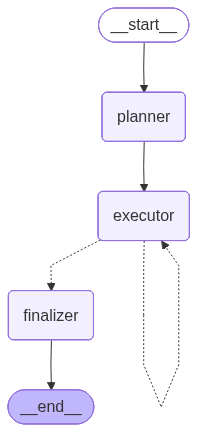

In [50]:
try:
    display(Image(plan_execute_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph: START -> planner -> executor (loops) -> finalizer -> END")

In [51]:
result = plan_execute_agent.invoke({
    "input": "Research what ReAct pattern is and explain it simply"
})

print(f"\n{'='*70}")
print("📊 FINAL OUTPUT:")
print(f"{'='*70}")
print(result["final_output"])
print(f"{'='*70}\n")


PLAN CREATED:
  1. **Define the ReAct Pattern**: Start by looking up the basic definition of the ReAct pattern in the context of programming or software development. Identify its purpose and key components.
  2. **Gather Resources**: Find reliable sources such as articles, tutorials, or videos that explain the ReAct pattern. Look for examples that illustrate how it is used in real-world applications.
  3. **Summarize Key Points**: Take notes on the most important aspects of the ReAct pattern, including its benefits, use cases, and any relevant examples. Aim to distill the information into simple terms.
  4. **Create a Simple Explanation**: Write a brief explanation of the ReAct pattern using the notes you gathered. Focus on clarity and simplicity, avoiding technical jargon where possible.
  5. **Review and Revise**: Read through your explanation to ensure it is easy to understand. Make any necessary adjustments to improve clarity and conciseness before finalizing your explanation.

Ex

#### Reflection Pattern

In [53]:
# Custom state for Reflection
class ReflectionState(TypedDict):
    """State for reflection pattern."""
    task: str  # Original task
    draft: str  # Current draft
    critique: str  # Critique of draft
    iterations: int  # Number of refinements
    final_output: str  # Final result

MAX_REFLECTIONS = 2  # Prevent infinite loops

print("Reflection state defined")

Reflection state defined


In [54]:
# Node 1 : Generator
def generator(state: ReflectionState) -> dict:
    """Generate or refine based on critique."""
    if state["iterations"] == 0:
        prompt = f"""Create a response for this task:

Task: {state['task']}

Provide a clear, complete answer."""
        print("\n Generating initial draft....")
    else:
        # Refinement based on critique
        prompt = f""""Improve this draft based on the critique:

Task: {state['task']}

Current draft: {state['draft']}

Critique: {state['critique']}

Create an improved version."""
        print(f"\n Refining (iteration {state['iterations']})...")

    response = llm.invoke([HumanMessage(content=prompt)])
    print("Draft Created\n")

    return {"draft": response.content}

# Node 2: Critic
def critic(state: ReflectionState) -> dict:
    """Evaluate draft and provide critique."""
    prompt = f"""Evaluate this response and provide constructive critique:

Task: {state['task']}

Response: {state['draft']}

Critique the response. What could be improved?
If it's excellent, say "APPROVED: explanation".
Otherwise, provide specific improvements needed."""
    
    print("Critiquing draft...")
    response = llm.invoke([HumanMessage(content=prompt)])
    critique = response.content

    print(f"Critique: {critique[:100]}\n")

    return {
        "critique": critique,
        "iterations": state["iterations"] + 1
    }

# Node 3: Finalizer
def reflection_finalizer(state: ReflectionState) -> dict:
    """Set final output."""
    print("\nReflection complete!\n")
    return {"final_output": state["draft"]}

print("reflection nodes defined")

reflection nodes defined


In [ ]:
# Routing function
def should_reflect_again(state: ReflectionState) -> Literal["generator", "finalizer"]:
    """Decide if we need more refinement."""
    if "APPROVED" in state.get("critique", "").upper():
        return "finalizer"
    if state["iterations"] >= MAX_REFLECTIONS:
        print(f"f Max iterations ({MAX_REFLECTIONS}) reached\n")
        return "finalizer"
    
    return "generator"

# Build Reflection graph
reflection_builder = StateGraph(ReflectionState)

reflection_builder.add_node("generator", generator)
reflection_builder.add_node("critic", critic)
reflection_builder.add_node("finalizer", reflection_finalizer)

reflection_builder.add_edge(START, "generator")
reflection_builder.add_edge("generator", "critic")
reflection_builder.add